In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/EV dataset/station_data_dataverse.csv")

In [40]:
# Basic Info
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sessionId       3395 non-null   int64  
 1   kwhTotal        3395 non-null   float64
 2   dollars         3395 non-null   float64
 3   created         3395 non-null   object 
 4   ended           3395 non-null   object 
 5   startTime       3395 non-null   int64  
 6   endTime         3395 non-null   int64  
 7   chargeTimeHrs   3395 non-null   float64
 8   weekday         3395 non-null   object 
 9   platform        3395 non-null   object 
 10  distance        2330 non-null   float64
 11  userId          3395 non-null   int64  
 12  stationId       3395 non-null   int64  
 13  locationId      3395 non-null   int64  
 14  managerVehicle  3395 non-null   int64  
 15  facilityType    3395 non-null   int64  
 16  Mon             3395 non-null   int64  
 17  Tues            339

In [41]:
# Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
sessionId            0
kwhTotal             0
dollars              0
created              0
ended                0
startTime            0
endTime              0
chargeTimeHrs        0
weekday              0
platform             0
distance          1065
userId               0
stationId            0
locationId           0
managerVehicle       0
facilityType         0
Mon                  0
Tues                 0
Wed                  0
Thurs                0
Fri                  0
Sat                  0
Sun                  0
reportedZip          0
dtype: int64


In [42]:
# Visualize unique station IDs
unique_station_ids = df['stationId'].unique()
print(f"Number of unique station IDs: {len(unique_station_ids)}")



Number of unique station IDs: 105


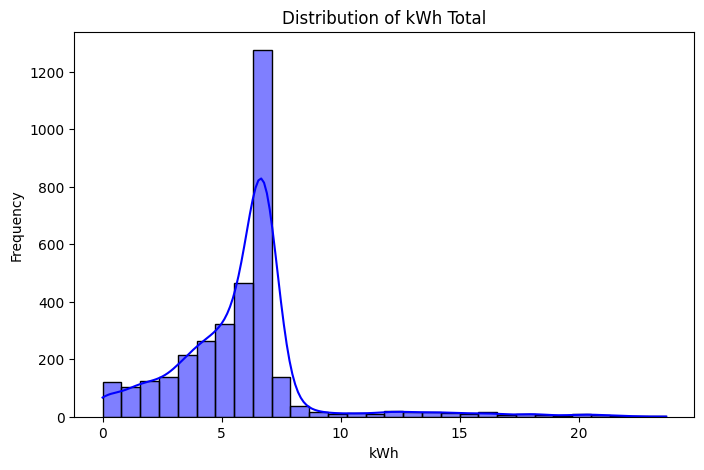

In [43]:
plt.figure(figsize=(8, 5))
sns.histplot(df['kwhTotal'], bins=30, kde=True, color='blue')
plt.title('Distribution of kWh Total')
plt.xlabel('kWh')
plt.ylabel('Frequency')
plt.show()


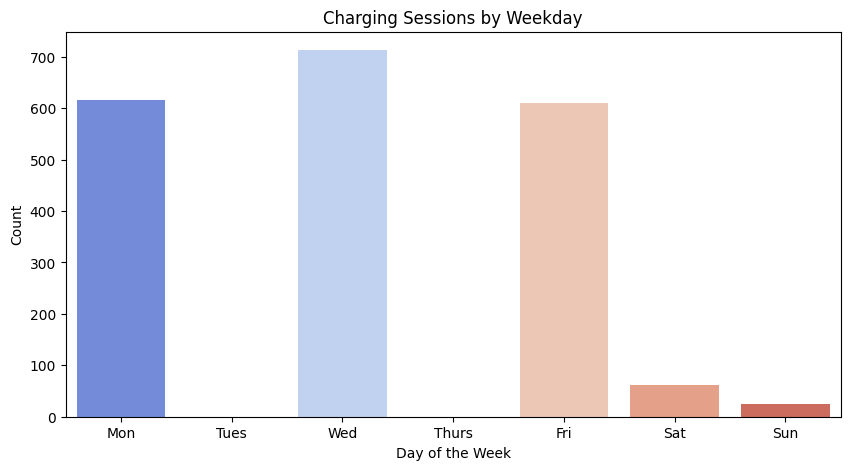

In [44]:
plt.figure(figsize=(10,5))
sns.countplot(x='weekday', data=df, order=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], palette='coolwarm')
plt.title("Charging Sessions by Weekday")
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.show()


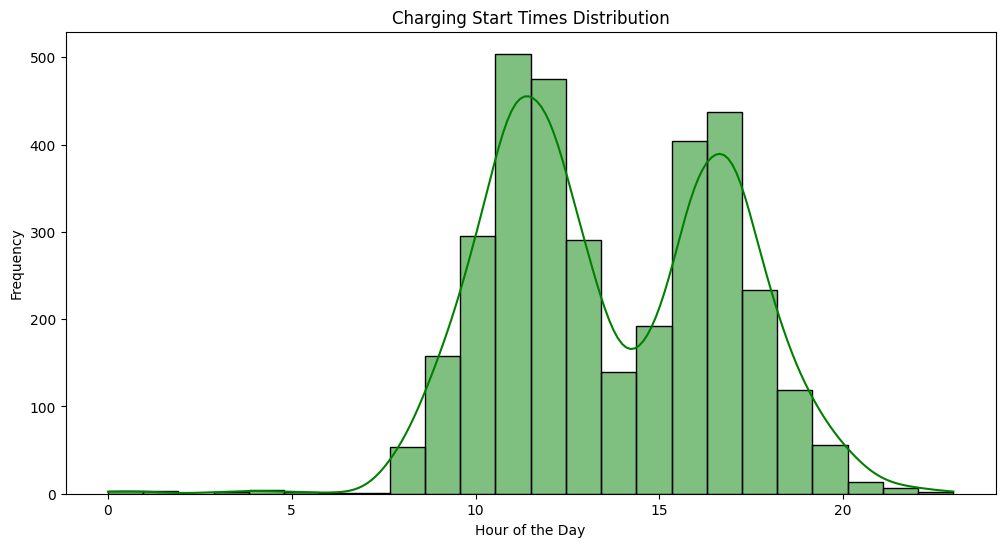

In [45]:
plt.figure(figsize=(12,6))
sns.histplot(df['startTime'], bins=24, kde=True, color='green')
plt.title("Charging Start Times Distribution")
plt.xlabel("Hour of the Day")
plt.ylabel("Frequency")
plt.show()


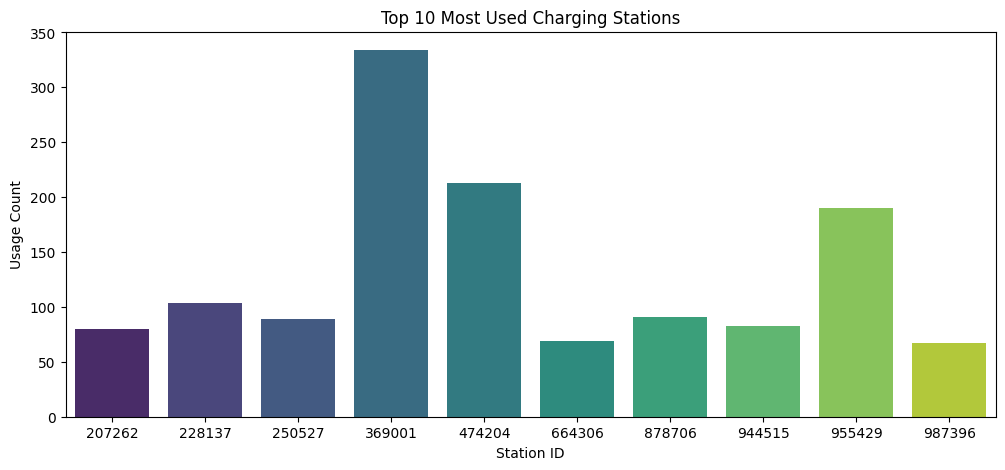

In [46]:
plt.figure(figsize=(12,5))
top_stations = df['stationId'].value_counts().head(10)
sns.barplot(x=top_stations.index, y=top_stations.values, palette="viridis")
plt.title("Top 10 Most Used Charging Stations")
plt.xlabel("Station ID")
plt.ylabel("Usage Count")
plt.show()


# Handle Missing Values

In [47]:
df['distance'].fillna(df['distance'].median(), inplace=True)


In [48]:
import pandas as pd
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")

In [49]:
df['created'] = df['created'].str.replace(r'^(00\d{2})', lambda x: str(int(x.group(1)) + 2000), regex=True)
df['created'] = pd.to_datetime(df['created'], format="%Y-%m-%d %H:%M:%S")

# Aggregate by hour to get charging station demand per hour
df['hour'] = df['created'].dt.floor('H')  # Round to nearest hour
df_hourly = df.groupby('hour').size().reset_index(name='charging_sessions')


In [15]:
# Check for stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is NOT stationary, differencing needed")

adf_test(df_hourly['charging_sessions'])
# Differencing if needed (making series stationary)
df_hourly['demand_diff'] = df_hourly['charging_sessions'].diff().dropna()


ADF Statistic: -3.5686434742037596
p-value: 0.0063895815542509725
Series is stationary


In [16]:

# Grid Search for ARIMA (p, d, q)
p = range(0, 4)
d = range(0, 2)
q = range(0, 4)
pdq_combinations = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

for order in pdq_combinations:
    try:
        model = ARIMA(df_hourly['charging_sessions'], order=order).fit()
        aic = model.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = model
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")



Best ARIMA order: (3, 1, 3) with AIC: 5538.683944025035


In [17]:
# Fit the best ARIMA model
final_model = ARIMA(df_hourly['charging_sessions'], order=best_order).fit()
print(final_model.summary())




                               SARIMAX Results                                
Dep. Variable:      charging_sessions   No. Observations:                 1537
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2762.342
Date:                Sun, 06 Apr 2025   AIC                           5538.684
Time:                        18:18:12   BIC                           5576.043
Sample:                             0   HQIC                          5552.585
                               - 1537                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0272      0.059     17.507      0.000       0.912       1.142
ar.L2         -1.0404      0.039    -26.952      0.000      -1.116      -0.965
ar.L3          0.2092      0.030      7.071      0.0

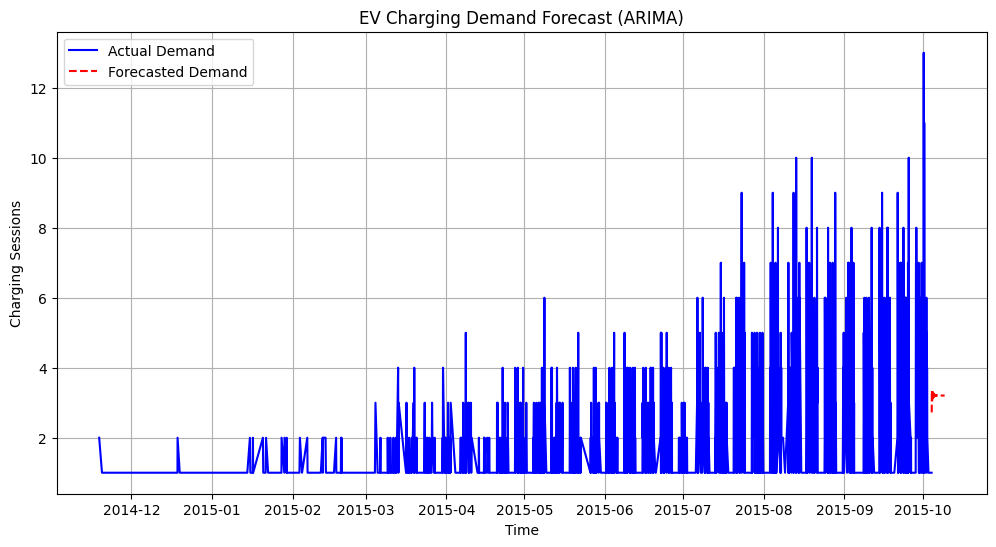

In [18]:
# Forecast next 120 hours (5 days)
forecast_steps = 120
forecast = final_model.forecast(steps=forecast_steps)

# Create a date range for future predictions
future_dates = pd.date_range(df_hourly['hour'].iloc[-1], periods=forecast_steps + 1, freq='H')[1:]

# Plot results
plt.figure(figsize=(12,6))
plt.plot(df_hourly['hour'], df_hourly['charging_sessions'], label="Actual Demand", color='blue')
plt.plot(future_dates, forecast, label="Forecasted Demand", color='red', linestyle='dashed')
plt.xlabel("Time")
plt.ylabel("Charging Sessions")
plt.title("EV Charging Demand Forecast (ARIMA)")
plt.legend()
plt.grid(True)
plt.show()

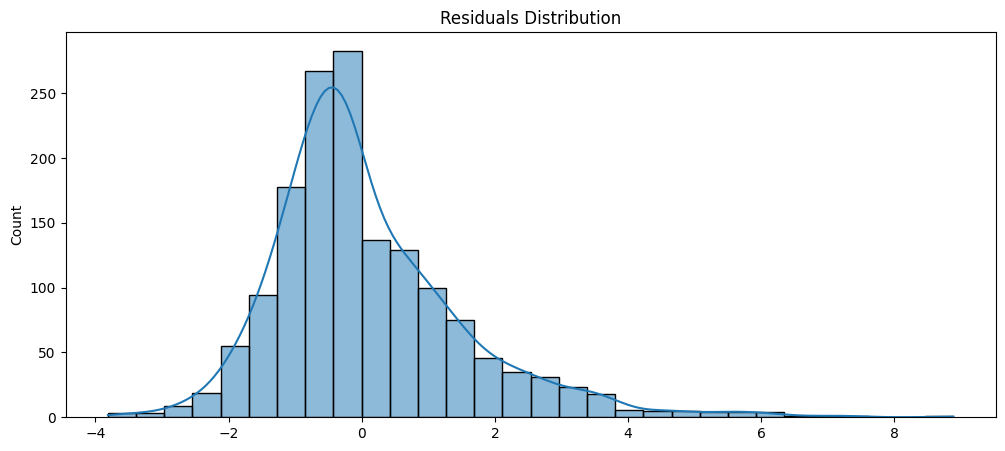

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = final_model.resid
plt.figure(figsize=(12, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.show()


# XGBOOST

In [50]:

# Aggregate by 'hour' and apply various aggregation functions
df_hourly = df.groupby('hour').agg(
    charging_sessions=('sessionId', 'nunique'),  # Count unique sessionIds for the number of sessions
    kwhTotal_sum=('kwhTotal', 'sum'),            # Sum of kWh for the hour
    kwhTotal_mean=('kwhTotal', 'mean'),          # Average kWh for the hour
    dollars_sum=('dollars', 'sum'),              # Sum of dollars for the hour
    dollars_mean=('dollars', 'mean'),            # Average dollars for the hour
    chargeTimeHrs_sum=('chargeTimeHrs', 'sum'),  # Sum of charge time in hours
    chargeTimeHrs_mean=('chargeTimeHrs', 'mean'), # Average charge time in hours
    distance_sum=('distance', 'sum'),            # Sum of distances for the hour
    distance_mean=('distance', 'mean'),          # Average distance for the hour
    weekday_mode=('weekday', lambda x: x.mode()[0]),  # Mode of the weekday (most frequent)
    platform_mode=('platform', lambda x: x.mode()[0]), # Mode of the platform
    stationId_mode=('stationId', lambda x: x.mode()[0]), # Mode of the stationId
    locationId_mode=('locationId', lambda x: x.mode()[0]), # Mode of the locationId
    managerVehicle_mode=('managerVehicle', lambda x: x.mode()[0]), # Mode of managerVehicle
    facilityType_mode=('facilityType', lambda x: x.mode()[0]),  # Mode of facilityType
).reset_index()



In [61]:
df_hourly

,hour,charging_sessions,kwhTotal_sum,kwhTotal_mean,dollars_sum,dollars_mean,chargeTimeHrs_sum,chargeTimeHrs_mean,distance_sum,distance_mean,weekday_mode,platform_mode,stationId_mode,locationId_mode,managerVehicle_mode,facilityType_mode
0,2014-11-18 15:00:00,2,13.39,6.695,0.00,0.00,4.923611,2.461806,41.719553,20.859777,Tue,android,582873,461655,0,3
1,2014-11-19 17:00:00,1,9.74,9.740,0.00,0.00,2.177222,2.177222,21.023826,21.023826,Wed,android,549414,461655,0,3
2,2014-11-19 19:00:00,1,9.03,9.030,0.00,0.00,3.140278,3.140278,20.695727,20.695727,Wed,ios,569889,461655,0,3
3,2014-11-20 19:00:00,1,6.95,6.950,0.00,0.00,2.455278,2.455278,20.695727,20.695727,Thu,ios,612116,461655,0,3
4,2014-11-21 12:00:00,1,6.76,6.760,0.58,0.58,4.671667,4.671667,21.023826,21.023826,Fri,android,129465,461655,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,2015-10-03 07:00:00,1,23.68,23.680,0.50,0.50,4.106667,4.106667,21.023826,21.023826,Sat,android,730023,878393,0,1
1533,2015-10-03 09:00:00,1,6.20,6.200,0.00,0.00,1.909167,1.909167,32.874546,32.874546,Sat,ios,369001,493904,1,1
1534,2015-10-03 12:00:00,1,6.08,6.080,0.00,0.00,2.995000,2.995000,5.135871,5.135871,Sat,ios,369001,493904,0,1
1535,2015-10-03 15:00:00,1,1.12,1.120,0.00,0.00,1.999167,1.999167,32.874546,32.874546,Sat,ios,369001,493904,1,1


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import train_test_split

In [57]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

# One-hot encode categorical columns or label encode them
df_hourly_encoded = pd.get_dummies(df_hourly, columns=['weekday_mode', 'platform_mode', 'stationId_mode', 'locationId_mode', 'managerVehicle_mode', 'facilityType_mode'], drop_first=True)

X = df_hourly_encoded.drop(columns=['hour', 'charging_sessions'])
y = df_hourly_encoded['charging_sessions']

# Assuming 'charging_sessions' is the target variable
X = df_hourly_encoded.drop(columns=['hour', 'charging_sessions'])
y = df_hourly_encoded['charging_sessions']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Grid search parameters
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.001, 0.001],
}

xgb_model = XGBRegressor()
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X, y)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.001, 0.001],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [59]:
best_xgb = grid_search.best_estimator_
print(f"\nBest XGBoost Params: {grid_search.best_params_}")

# Evaluate
y_pred = best_xgb.predict(X_test)

# Evaluation metrics
def evaluate_model(y_true, y_pred, name="Model"):
    print(f"\n{name} Evaluation:")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE  : {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R2   : {r2_score(y_true, y_pred)}")
    print(f"MAPE : {mean_absolute_percentage_error(y_true, y_pred)}%")

evaluate_model(y_test, y_pred, name="XGBoost")


Best XGBoost Params: {'learning_rate': 0.05, 'n_estimators': 100}

XGBoost Evaluation:
MAE  : 0.016830287873744965
MSE  : 0.0008230368257500231
RMSE : 0.02868861840085756
R2   : 0.9997409582138062
MAPE : 0.0081477090716362%


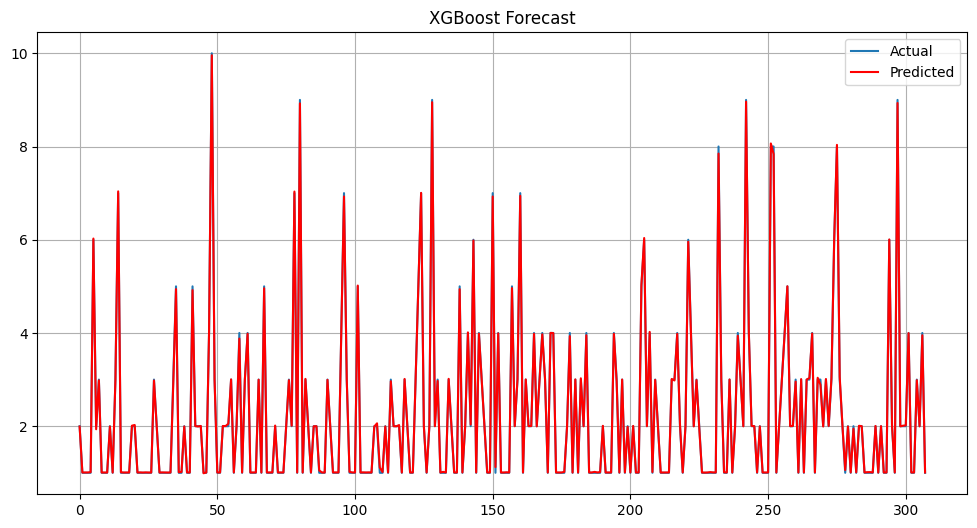

In [60]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted", color='red')
plt.legend()
plt.title("XGBoost Forecast")
plt.grid()
plt.show()


# LSTM

In [62]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [76]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [77]:
# Normalize the data (min-max scaling) since LSTM models require normalized values
scaler = MinMaxScaler(feature_range=(0, 1))
df_hourly_scaled = scaler.fit_transform(df_hourly_encoded.drop(columns=['hour', 'charging_sessions']))

# Prepare data for LSTM (reshape to 3D array)
def create_lstm_dataset(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Convert the features and target to numpy arrays
X = df_hourly_scaled
y = df_hourly_encoded['charging_sessions'].values

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [81]:

# Define a function to create and compile the LSTM model
def create_lstm_model(units=50, dropout_rate=0.2, time_steps=1):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(time_steps, X_train.shape[1])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Hyperparameter grid for tuning
param_grid = {
    'time_steps': [5, 10, 20],  # Different time steps to test
    'units': [50, 100, 200],         # Number of LSTM units
    'dropout_rate': [0.2, 0.3], # Dropout rate to prevent overfitting
    'batch_size': [32],     # Batch size
    'epochs': [ 20]          # Number of epochs
}

# Function for evaluating LSTM model with hyperparameters
def evaluate_lstm_model(param_grid):
    best_mae = float('inf')
    best_params = None
    best_model = None
    best_results = None

    # Loop through all combinations of hyperparameters in the grid
    for time_steps in param_grid['time_steps']:
        for units in param_grid['units']:
            for dropout_rate in param_grid['dropout_rate']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:

                        # Create LSTM dataset
                        X_train_lstm, y_train_lstm = create_lstm_dataset(X_train, y_train, time_steps)
                        X_test_lstm, y_test_lstm = create_lstm_dataset(X_test, y_test, time_steps)

                        # Reshape to 3D for LSTM input: [samples, time_steps, features]
                        X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2])
                        X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], X_test_lstm.shape[2])

                        # Create model
                        model = create_lstm_model(units=units, dropout_rate=dropout_rate, time_steps=time_steps)

                        # Early stopping
                        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                        # Train the model
                        model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=batch_size,
                                  validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping], verbose=2)

                        # Predict on test set
                        y_pred_lstm = model.predict(X_test_lstm)

                        # Calculate evaluation metrics
                        mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
                        mse = mean_squared_error(y_test_lstm, y_pred_lstm)
                        rmse = np.sqrt(mse)
                        r2 = r2_score(y_test_lstm, y_pred_lstm)

                        # Calculate MAPE
                        mape = np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100

                        # If this model is better, update the best parameters and model
                        if mae < best_mae:
                            best_mae = mae
                            best_params = (time_steps, units, dropout_rate, batch_size, epochs)
                            best_model = model
                            best_results = (mae, mse, rmse, r2, mape, y_test_lstm, y_pred_lstm)

    return best_params, best_results

# Run the hyperparameter search and get the best model
best_params, best_results = evaluate_lstm_model(param_grid)



Epoch 1/20
39/39 - 3s - 67ms/step - loss: 4.2485 - val_loss: 3.2266
Epoch 2/20
39/39 - 1s - 27ms/step - loss: 2.7322 - val_loss: 3.2457
Epoch 3/20
39/39 - 0s - 12ms/step - loss: 2.7154 - val_loss: 3.2192
Epoch 4/20
39/39 - 1s - 16ms/step - loss: 2.6833 - val_loss: 3.2351
Epoch 5/20
39/39 - 1s - 13ms/step - loss: 2.5879 - val_loss: 3.2420
Epoch 6/20
39/39 - 1s - 15ms/step - loss: 2.6029 - val_loss: 3.2576
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/20
39/39 - 3s - 66ms/step - loss: 4.0035 - val_loss: 3.1997
Epoch 2/20
39/39 - 0s - 10ms/step - loss: 2.7605 - val_loss: 3.2103
Epoch 3/20
39/39 - 1s - 15ms/step - loss: 2.6652 - val_loss: 3.2185
Epoch 4/20
39/39 - 0s - 8ms/step - loss: 2.6905 - val_loss: 3.2534
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/20
39/39 - 4s - 95ms/step - loss: 3.8049 - val_loss: 3.2941
Epoch 2/20
39/39 - 0s - 12ms/step - loss: 2.6810 - val_loss: 3.2403
Epoch 3/20
39/39 - 0s - 11ms/step - loss: 2.6494 - val_loss: 3.3162
Epoch 4/20
39/39 - 1s - 13ms/step - l

In [82]:
# Extract best model results
best_time_steps, best_units, best_dropout_rate, best_batch_size, best_epochs = best_params
best_mae, best_mse, best_rmse, best_r2, best_mape, best_y_test, best_y_pred = best_results

# Print the evaluation metrics for the best model
print(f"Best Model (Time Steps: {best_time_steps}, Units: {best_units}, Dropout Rate: {best_dropout_rate}, Batch Size: {best_batch_size}, Epochs: {best_epochs})")
print(f"Mean Absolute Error: {best_mae}")
print(f"Mean Squared Error: {best_mse}")
print(f"Root Mean Squared Error: {best_rmse}")
print(f"R-Squared: {best_r2}")
print(f"Mean Absolute Percentage Error (MAPE): {best_mape}")
print("-" * 50)



Best Model (Time Steps: 5, Units: 200, Dropout Rate: 0.2, Batch Size: 32, Epochs: 20)
Mean Absolute Error: 1.2728447914123535
Mean Squared Error: 3.2543506622314453
Root Mean Squared Error: 1.8039818907714804
R-Squared: -0.01490771770477295
Mean Absolute Percentage Error (MAPE): 67.85018316991047
--------------------------------------------------


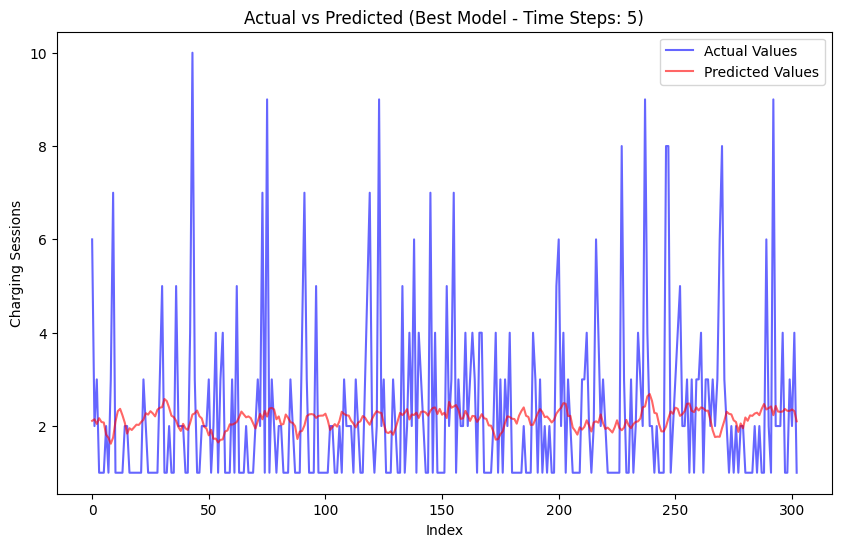

In [83]:
# Plot Actual vs Predicted values for the best model
plt.figure(figsize=(10, 6))
plt.plot(best_y_test, label='Actual Values', color='blue', alpha=0.6)
plt.plot(best_y_pred, label='Predicted Values', color='red', alpha=0.6)
plt.title(f'Actual vs Predicted (Best Model - Time Steps: {best_time_steps})')
plt.xlabel('Index')
plt.ylabel('Charging Sessions')
plt.legend()
plt.show()
